<a href="https://colab.research.google.com/github/ashalem/ML_Human/blob/main/WS2_2024_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>Machine Learning and Human Behavior - 236667 - Winter 2024-2025</div>
<font size="6">Workshop #2 - Discrete Choice ✨</font>

# Instructions and submission guidelines

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in text (markdown) blocks, and wet questions in code blocks.
* Submission guidelines:
    * When you're done, restart the notebook, and make sure that everything runs smoothly (Runtime->"Restart and Run All")
    * Add a text block in the beginning of your notebook with your IDs.
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * If you need to attach additional files to your submission (e.g images), add them to a zip file together with the notebook ipynb file.
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Sunday 15/12/2024, 10:00
* For any questions regarding this workshop task, contact [Lotan](mailto:lotan.amit@campus.technion.ac.il).


## Preliminaries
Run these cells to load into memory interface objects and functions that will be used throughtout today's workshop.

No need to read the actual code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import abc
import string
import statsmodels.api as sm
import itertools
from sklearn import svm, linear_model
import pandas as pd
import sys

from collections import OrderedDict

%config InlineBackend.figure_format = 'retina'

In [2]:
#@title Context Effects

# Generate Choice

class UserModel(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, X, *args):
    '''
    Given items X, calculate the user's valuation v(x) for each item x
    '''
    raise NotImplementedError()

  def predict(self, X, *args):
    raise NotImplementedError()

class RationalUserModel(UserModel):

  def __init__(self, beta_h):
    self.beta_h = beta_h
    self.type = "rational"

  def __call__(self, X):
    return X@self.beta_h

  def choice(self, X):
    return np.argmax(self(X), axis=0)


class AttractionUserModel(UserModel):
  def __init__(self, beta_h, alpha_attr):
    # rational_utility_weights
    self.rational_utility_weights = beta_h
    # attraction_coefficient
    self.attraction_coefficient = alpha_attr
    self.name = "attraction"

  def __call__(self, X):
    # X: shape=(num_items,num_features) - Item covariates
    return (
        self._rational_decision_term(X)
        + self.attraction_coefficient*self._attraction_term(X)
    )

  def _rational_decision_term(self, X):
    return X@self.rational_utility_weights

  def _attraction_term(self, X):
    # Calculate preference vector
    preference_vector = X.max(axis=0)-X.min(axis=0)
    preference_vector_normalized = (
        preference_vector
        /np.sqrt(preference_vector@preference_vector)
    )
    # Calculate dominance and distance matrices
    N = len(X)
    dominance = np.zeros((N,N))
    distance = np.zeros((N,N))
    for i in range(N):
      for j in range(N):
        dominance[i,j] = (+1)*np.all(X[i]-X[j] >= 0) + (-1)*np.all(X[j]-X[i] >= 0)
        distance[i,j] = abs(preference_vector_normalized@(X[i]-X[j]))

    attraction_terms = (dominance*distance).sum(axis=1)
    return attraction_terms

  def choice(self, X):
    return np.argmax(self(X), axis=0)



class SimilarityUserModel(UserModel):

  def __init__(self, beta_h, beta_sim):
    self.beta_h = beta_h
    self.beta_sim = beta_sim
    self.name = "similarity"

  def __call__(self, X):

    # calculate actual value
    v_ih = X@self.beta_h

    # calculate perference vector
    pref_vec = X.max(axis=0) - X.min(axis=0)


    # project on the ortogonal hyperplane
    X_projected = np.zeros(X.shape)
    projection_size = np.zeros(X.shape[0])

    for i in range(X.shape[0]):
        X_projected[i, :] = X[i,:] -  (X[i,:].dot(pref_vec) / np.linalg.norm(pref_vec)) * pref_vec

    # find min distance on projected

    distances = np.zeros((X_projected.shape[0], X_projected.shape[0]))

    for i in range(X_projected.shape[0]): # could be optimized (cal half mat etc..)
      for j in range(X_projected.shape[0]):
        distances[i,j] = np.linalg.norm(X_projected[i,:] - X_projected[j,:])

    # avoide i == j
    distances = distances + np.eye(distances.shape[0])*distances.max()

    min_distances = distances.min(axis=1) # go over columns

    return v_ih + self.beta_sim*min_distances

  def choice(self, X):
    return np.argmax(self(X))


class CompromiseUserModel(UserModel):

  def __init__(self, beta_h, beta_com):
    self.beta_h = beta_h
    self.beta_com = beta_com
    self.name = 'compromise'

  def __call__(self, X):

    # calculate rational value
    v_ih = X@self.beta_h
    # calculate compromise value
    X_com = (X.max(axis=0) + X.min(axis=0)) / 2

    # pairwise distance between rows of X and X_com
    d_im = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        d_im[i] = np.linalg.norm(X[i,:] - X_com)

    return v_ih + -d_im*self.beta_com

  def x_user_choice_positions(self, X):
    return np.argmax(self(X), axis=0)

In [3]:
#@title Context Environment

Counter = 0

class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 8
    observations_per_user = 10
    items_per_slate = 1
    train_user_proportion = 0.6


    def _generate_user_item_attributes(self, n_users):
        """
        Generate latent parameters for users and items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, items_per_slate, n_features)
        """
        users = np.random.normal(
            size=(
                n_users,
                self.n_features,
            ),
        )
        items = np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.items_per_slate,
                self.n_features,
            ),
        )
        return users, items

    def _choice(self, users, items):
        """
        Discrete choice function

        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, items_per_slate, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError

    def _generate_choice_dataset(self, n_users):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users, items = self._generate_user_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = f'{i}'
                dct['slate_id'] = f'{i}_{j}'
                for k in range(self.items_per_slate):
                    for l in range(self.n_features):
                        dct[f'x_{k},{l}'] = items[i,j,k,l]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df

    def generate_datasets(self, n_users):
        n_train_users = int(n_users*self.train_user_proportion)
        n_test_users = n_users - n_train_users
        return (
            self._generate_choice_dataset(n_train_users),
            self._generate_choice_dataset(n_test_users),
        )


class ContextChoiceEnvironment(DiscreteChoiceEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def __init__(self,
                 slate_number=3,
                 observations_per_user=50,
                 num_items_omega=15):

        # self.noise_scale = noise_scale
        user_model = AttractionUserModel(
        beta_h=np.array([1,9]),
          alpha_attr=3,
      )

        self.total_item_count = 0
        self.user_model = user_model
        self.slate_number = slate_number
        self.observations_per_user = observations_per_user
        self._generate_ex1_items(slate_number=slate_number,
                                 num_items_omega=num_items_omega)
        self.Counter = 0


    def _generate_ex1_items(self, slate_number=3, num_items_omega=15):
      if slate_number == 1:
        self.omega = np.array([[1,3,3,4,10,4,2],[1,7.5,5,4,5,6,1]])
        self.E_s = np.array([10, 20, 80, 40, 30, 80, 100])
        self.omega_tag = np.array([[4,2.5,4.5],[4.5,6,5]])
        self.E_s_tag = np.array([5, 8, 3])

      elif slate_number == 2:
        self.omega = np.array([[3,8,8.5,4,10,8,2, 1],[8,7,4,4,5,6,1, 8]])
        self.E_s = np.array([10, 90, 30, 50, 30, 40,100,90])

        self.omega_tag = np.array([[4,3,4.5,6],[8,6,5,6]])
        self.E_s_tag = np.array([5, 8, 3, 9])

      else:
        np.random.seed(24)
        num_items_omega = 15
        self.omega, self.omega_tag = list(), list()
        self.E_s, self.E_s_tag = list(), list()

        for i in range(self.observations_per_user):
          self.omega.append(np.hstack([np.zeros((num_items_omega, 1)),
                                        np.ones((num_items_omega, 1))*i,
                                        np.random.randint(
                                            20,size=(num_items_omega,2)),
                                       np.random.randint(
                                           20,100,size=(num_items_omega,1))
                                        ]
                                       )
          )

          self.omega_tag.append(np.hstack([np.zeros((100, 1)),
                              np.ones((100, 1))*i,
                              np.random.randint(
                                  20,size=(100,2)),
                              np.random.randint(20,size=(100,1))
                              ]
                              )
          )

        self.omega = np.vstack(self.omega).T
        self.omega_tag = np.vstack(self.omega_tag).T
        self._items_to_frame(self.omega,self.E_s, data_name="Omega")
        self._items_to_frame(self.omega_tag, self.E_s_tag, ord('I'),
                                     data_name="Omega_tag")

      return

    def _items_to_frame(self, omega, E_s, char_start=ord('A'), data_name="Omega"):

        data = pd.DataFrame(omega.T).reset_index()
        data['index'] += self.total_item_count
        self.total_item_count += len(data)
        data.rename(columns={'index':'item_id'}, inplace=True)
        # data.set_index('item_id', inplace=True)

        if len(data) < self.observations_per_user:
          data['user_id'] = np.zeros(len(data))
          data['slate_id'] = np.zeros(len(data))
          data['rational_user_val'] = omega.T@\
                            self.user_model.rational_utility_weights
          data["E_s"] = E_s

        else:
          data['rational_user_val'] = data.loc[:,[2,3]].values@\
                  self.user_model.rational_utility_weights

          data.rename(columns={0:'user_id', 1:'slate_id',
                               2:'x_0', 3:'x_1', 4:'E_s'},
                      inplace=True)

        data['name'] = 'itm_' + data['item_id'].astype(str)
        # 'N/A' #data['index'].apply(lambda x: chr(char_start+x))

        if data_name == "Omega":
          self.omega_df = data
        else:
          self.omega_tag_df = data

        return data

    def generate_slate_data_set(self, slate_id):

          # data = self.omega_df.loc[self.omega_df.slate_id == slate_id].reset_index().drop(columns=["level_0"])
          # data = self.omega_df.loc[self.omega_df.slate_id == slate_id]
          data = self.omega_df.query('slate_id==@slate_id').copy()

          # self.top_5 = data.rational_user_val.argsort()[-5:][::-1]
          self.top_5 = data.rational_user_val.sort_values(ascending=False).iloc[:5].index
          # data['top_5'] = data['index'].apply(lambda x: int(x) in self.top_5.values)
          data['perceived_val'] = np.nan
          feature_cols = [col for col in data.columns if col.startswith('x')]
          data.loc[self.top_5, ['perceived_val']] = self.user_model(
              data.loc[self.top_5, feature_cols].values)
          data = self._choice(data)

          return data


    def inspect_data(self, items_type="current", slate_id=-1):
      if items_type == "current":
        data = self.omega_df
      elif items_type == "tag":
        data = self.omega_tag_df


      # if items_type == "current":
      #   data =  self._items_to_frame(self.omega,self.E_s, data_name="Omega")
      # elif items_type == "tag":
      #   data =  self._items_to_frame(self.omega_tag, self.E_s_tag, ord('A') + len(self.E_s),
      #                                data_name="Omega_tag")
      if slate_id == -1:
        return data
      else:
        return data.loc[data.slate_id == slate_id]


    def generate_datasets(self, slate_id=-1):
      self.Counter = self.Counter + 1
      data = pd.DataFrame(self.omega.T).reset_index()

      if len(data) < self.observations_per_user:
        data['user_id'] = np.zeros(len(data))
        data['slate_id'] = np.zeros(len(data))
        # data['name'] = #data['index'].apply(lambda x: chr(ord('A')+x))
        data['name'] = 'itm_' + data['item_id'].astype(str)
        data['rational_user_val'] = self.omega.T@\
                                    self.user_model.rational_utility_weights
        # self.top_5 = data.rational_user_val.argsort()[-5:][::-1]
        self.top_5 = data.rational_user_val.sort_values(ascending=False).iloc[:5].index
        print(self.top_5)
        data['top_5'] = data['index'].apply(lambda x: x.index in self.top_5)
        data['perceived_val'] = np.nan
        data.loc[self.top_5, ['perceived_val']] = self.user_model(data.loc[self.top_5, [0,1]].values)
        res = self._choice(data)

      else:
        # if slate_id != -1:
        res = self.generate_slate_data_set(slate_id)

      return res

    def _choice(self, data, chosen='chosen'):
        # dummies = pd.get_dummies(data.index)
        # for name, group in grouped:
        self.chosen = data['perceived_val'].astype(float).idxmax()
        # data[chosen] = dummies.loc[data['perceived_val'].astype(float).idxmax(), :]
        data[chosen] = (data['perceived_val'] == data['perceived_val'].max()).astype(int)
        return data

    def add_item(self, item_id):
      assert (self.omega_tag_df.item_id==item_id).any(), f'Item {item_id} not in omega_tag'
      assert (self.omega_df.item_id!=item_id).all(), f'Item {item_id} already in omega'
      item = self.omega_tag_df.loc[self.omega_tag_df["item_id"] == item_id].copy()
      self.omega_df = pd.concat([
          self.omega_df,
          item,
      ])

      self.omega_df = self.omega_df.set_index(['item_id']).reset_index()

    def drop_item(self, item_id):
      assert (self.omega_df.item_id==item_id).any(), f'Item {item_id} not in omega'
      # item_slate = self.omega_df.loc[self.omega_df.item_id == item_id].slate_id.iloc[0]
      # item_index = self.omega_df.loc[self.omega_df.item_id == item_id].index
      # self.omega_df.drop(index = item_id, inplace=True)
      self.omega_df = self.omega_df.query('item_id != @item_id')

    def top_5_idx(self, rational_user_val):
      return rational_user_val.sort_values(ascending=False).iloc[:5].index


In [4]:
#@title Train Context Environment

class TrainContextChoiceEnvironment(DiscreteChoiceEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def __init__(self,
                 observations_per_user=500,
                 num_items=7,
                 num_features=5):

        self.user_models = {
            'Attraction' : AttractionUserModel( np.arange(num_features),100),
            'Compromise' : CompromiseUserModel(np.arange(num_features), 100),
            'Similarity' : SimilarityUserModel(np.arange(num_features), 100),
            'Rational' : RationalUserModel(np.arange(num_features)),
            }

        self.observations_per_user = observations_per_user
        self.items_per_slate = num_items
        self.n_features = num_features
        self._generate_user_item_attributes(1)

    def generate_datasets(self, num_features=5, num_items=7):

          # df_train, df_test = list(), list()
          # num_slates = self.omega_df.slate_id.nunique()
          # train_slates = int(0.8*num_slates)

          # for slate in range(train_slates):
          #   df_train.append(self.generate_slate_data_set(slate))

          # for slate in range(train_slates, num_slates):
          #   df_test.append(self.generate_slate_data_set(slate))
          # train_data = pd.concat(df_train).drop(columns=['name', 'index',])
          # test_data = pd.concat(df_test)

          # train_label = train_data['chosen']
          # test_label = test_data['chosen']
          self.items_per_slate = num_items
          self.num_features = num_features

          train_slates = int(0.8*self.observations_per_user)
          train_data, y_train = self._generate_choice_dataset(num_features=num_features,
                                                     num_slates=train_slates,
                                                      num_items=num_items)

          test_slates = self.observations_per_user - train_slates
          test_data, y_test = self._generate_choice_dataset(num_features=num_features,
                                                    num_slates=test_slates,
                                                    num_items=num_items)



          return train_data, test_data, y_train, y_test


    def _choice(self, data):
        dummies = pd.get_dummies(range(len(data)))
        chosen = dummies[data.astype(float).argmax()]
        return chosen

    def _generate_choice_dataset(self, num_features=5, num_slates=500, num_items=7):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        _, items = self._generate_user_item_attributes(0)


        y_train = {name:[] for name,user in self.user_models.items()}
        train = list()
        for i in range(num_slates):
            train.append(np.hstack(
                      [np.ones((num_items, 1))*i, # slate_id
                      np.random.normal(size=(num_items,num_features)), # data
                                                    ]))
            for name, user in self.user_models.items():
              y_train[name].append(self._choice(user(train[-1][:,1:])))

        feature_names = [f'x_{i}' for i in range(num_features)]
        col_names = ['slate_id'] + feature_names
        train_df = pd.DataFrame(np.vstack(train),
                                columns=col_names)

        for name, choices in y_train.items():
          train_df[name] = np.hstack(choices)

        train_data = train_df[col_names]#.drop(columns=['slate_id'])
        y = train_df[list(y_train.keys()) + ['slate_id']]
        return train_data, y

    def mean_welfare(self, X):
      return (X@np.arange(self.num_features)).mean()




# enV2 = TrainContextChoiceEnvironment(num_features=5, num_items=7)
# enV2.generate_datasets(num_features=5, num_items=7)

# add slate id to label, see which entry is value before doing so

# Task 1: Engineering Choice Sets

In this section, we build on the framework introduced in $HW2$ and construct sets of available items that cause (non-rational) users to choose items that are bad for them (i.e., have suboptimal value), but good for the system. In particular, users in this task will be susceptible to the *Attraction* context effect, and the way you construct the set of items should make use of this knowledge.

#### Here is a **reminder** for $HW2$ settings:

----------------------------------------

**Recommendation procedure:**
1. The collection of available items is the *ground set* $\Omega=\{x_1,...,x_n\}$ ($n$ may be different in different parts of this task). Each item $x \in s$ is described by two features, $x=(x_1, x_2)$.
2. There is a single user whose (true) value function is $v(x)=\alpha^\top x$. I.e., if the user chooses item $x_i$, then she receives $\alpha_1\cdot x_{i1} + \alpha_2\cdot x_{i2}$ utility from this choice. **The value vector $\alpha$ is known to the system**.
3. System also benefits from user choices. If the user chooses item $x_i$, then the system receives $e_i$ utility. The values $e_i$ are predetermined, known to the system, and do not depend on features.
4. The system recommends to the user the top-5 items $x\in \Omega$ having highest value. We will call this the *choice set*, denoted $s \in \Omega$.
5. The user chooses exactly one item $x \in s$. This is the item with highest *perceived value*, as determined by the attraction effect:
$$
  \tilde{v}(x|s) = \alpha^\top x + \mathtt{att}(x|s)
$$
where $\mathtt{att}$ is as was defined in class. We will denote the chosen item by $y = \mathtt{argmax}_{x \in s} \tilde{v}(x|s)$.
6. User receives utility $v(y)$, and system receives utility $e_y$.

----------------------------------------

In the above description, the system recommends in a way that is optimal to users. In this task, *you are an agent of the system*, and your goal is to maximize the system's utility.

Of course, you cannot simply force the user to choose a certain item, nor can you change the recommendation procedure. The only thing you are allowed to do is to modify $\Omega$ by adding one additional item from a different set of items, $\Omega'$. Once $\Omega$ is modified (i.e., includes one additional item), the recommendation procedure and user choice behavior is as described above.
Hence, your goal is to (manually) choose $x \in \Omega$ such that the choice $y$ derived from a top-5 recommended set $s$ based on the collection of items $\Omega \cup \{x\}$ will results in high system utility $e_y$ (and possibly with lower utility $v(y)$ to the user).

As you will see, items in  $\Omega'$ actually have lower system values $e_i$ than items in $\Omega$ ($\forall e \in E_S, e' \in E_S':  e > e'$). Therefore, the item you add will serve as a *decoy*: these serve to modify the preceived values of items in $s$, in a way that utilizes the attraction effect to affect choice behavior.



**In this section, you will write a simple algorithm that automatically finds the optimal item in $\Omega'$ to add to $\Omega$ in order to maximize system utility.**



### 1.1 Warm up

Here we explore with useful functions of ```ContextChoiceEnvironment```.

Note that user parameters are:
\begin{align}
\alpha_1 = 1, \alpha_2 = 9
\end{align}



In [5]:
env = ContextChoiceEnvironment()

Use ```inspect_data``` to view $Ω$ and $Ω'$ (using "current" and "tag" inputs strings). Note that this time the data contains multiple slates



In [6]:
env.inspect_data("current")

,item_id,user_id,slate_id,x_0,x_1,E_s,rational_user_val,name
0,0,0.0,0.0,2.0,3.0,66.0,29.0,itm_0
1,1,0.0,0.0,0.0,17.0,85.0,153.0,itm_1
2,2,0.0,0.0,17.0,1.0,67.0,26.0,itm_2
3,3,0.0,0.0,4.0,15.0,94.0,139.0,itm_3
4,4,0.0,0.0,4.0,15.0,55.0,139.0,itm_4
...,...,...,...,...,...,...,...,...
745,745,0.0,49.0,9.0,14.0,47.0,135.0,itm_745
746,746,0.0,49.0,12.0,6.0,67.0,66.0,itm_746
747,747,0.0,49.0,3.0,10.0,31.0,93.0,itm_747
748,748,0.0,49.0,6.0,10.0,97.0,96.0,itm_748


In [7]:
env.inspect_data("tag")

,item_id,user_id,slate_id,x_0,x_1,E_s,rational_user_val,name
0,750,0.0,0.0,7.0,5.0,11.0,52.0,itm_750
1,751,0.0,0.0,19.0,10.0,10.0,109.0,itm_751
2,752,0.0,0.0,9.0,0.0,3.0,9.0,itm_752
3,753,0.0,0.0,14.0,2.0,14.0,32.0,itm_753
4,754,0.0,0.0,11.0,4.0,6.0,47.0,itm_754
...,...,...,...,...,...,...,...,...
4995,5745,0.0,49.0,13.0,18.0,8.0,175.0,itm_5745
4996,5746,0.0,49.0,17.0,3.0,19.0,44.0,itm_5746
4997,5747,0.0,49.0,17.0,1.0,13.0,26.0,itm_5747
4998,5748,0.0,49.0,14.0,17.0,19.0,167.0,itm_5748


The following method are used to add and pop items from $Ω$:
*  Method ```env.add_item(item_id=i)``` is used to add an item from $Ω'$ to $Ω$ according to its index at $Ω'$ (as in $HW2$).

*   Method ```env.drop_item(item_id=i)``` is used to drop item i from $Ω$.

Both return none.

Use these to add item with item_id 750 from $Ω'$'s slate_id==0 and add it to $Ω$'s slate_id==0.
Then remove this item from $Ω$'s slate_id==0.
Print DataFrame at each stage using ```inspect_data``` fuction with ```slate_id=0```:


In [8]:
## YOUR SOLUTION
env.add_item(item_id=750)
env.inspect_data(slate_id=0)

,item_id,user_id,slate_id,x_0,x_1,E_s,rational_user_val,name
0,0,0.0,0.0,2.0,3.0,66.0,29.0,itm_0
1,1,0.0,0.0,0.0,17.0,85.0,153.0,itm_1
2,2,0.0,0.0,17.0,1.0,67.0,26.0,itm_2
3,3,0.0,0.0,4.0,15.0,94.0,139.0,itm_3
4,4,0.0,0.0,4.0,15.0,55.0,139.0,itm_4
5,5,0.0,0.0,3.0,18.0,84.0,165.0,itm_5
6,6,0.0,0.0,11.0,3.0,47.0,38.0,itm_6
7,7,0.0,0.0,19.0,15.0,53.0,154.0,itm_7
8,8,0.0,0.0,7.0,9.0,23.0,88.0,itm_8
9,9,0.0,0.0,18.0,7.0,24.0,81.0,itm_9


In [9]:
## YOUR SOLUTION
env.drop_item(item_id=750)
print(env.inspect_data(slate_id=0))
print(env.inspect_data(slate_id=0)["item_id"].values)

    item_id  user_id  slate_id   x_0   x_1   E_s  rational_user_val    name
0         0      0.0       0.0   2.0   3.0  66.0               29.0   itm_0
1         1      0.0       0.0   0.0  17.0  85.0              153.0   itm_1
2         2      0.0       0.0  17.0   1.0  67.0               26.0   itm_2
3         3      0.0       0.0   4.0  15.0  94.0              139.0   itm_3
4         4      0.0       0.0   4.0  15.0  55.0              139.0   itm_4
5         5      0.0       0.0   3.0  18.0  84.0              165.0   itm_5
6         6      0.0       0.0  11.0   3.0  47.0               38.0   itm_6
7         7      0.0       0.0  19.0  15.0  53.0              154.0   itm_7
8         8      0.0       0.0   7.0   9.0  23.0               88.0   itm_8
9         9      0.0       0.0  18.0   7.0  24.0               81.0   itm_9
10       10      0.0       0.0   3.0  13.0  85.0              120.0  itm_10
11       11      0.0       0.0   0.0  12.0  30.0              108.0  itm_11
12       12 

Similarlty to $HW2$, method ```env.generate_datasets``` generates a DataFrame indicating whether an item in $Ω$ is selected to Top 5 and displayed to the user, its precieved value, and the final choice by the user.
Now that we work with multiple slates we will provide **slate_id** as input.

Use ```generate_datasets``` to print such dataframe for slate 0:

In [10]:
## YOUR SOLUTION
df_slate_0 = env.generate_datasets(slate_id=0)

In [11]:
print(df_slate_0)

    item_id  user_id  slate_id   x_0   x_1   E_s  rational_user_val    name  \
0         0      0.0       0.0   2.0   3.0  66.0               29.0   itm_0   
1         1      0.0       0.0   0.0  17.0  85.0              153.0   itm_1   
2         2      0.0       0.0  17.0   1.0  67.0               26.0   itm_2   
3         3      0.0       0.0   4.0  15.0  94.0              139.0   itm_3   
4         4      0.0       0.0   4.0  15.0  55.0              139.0   itm_4   
5         5      0.0       0.0   3.0  18.0  84.0              165.0   itm_5   
6         6      0.0       0.0  11.0   3.0  47.0               38.0   itm_6   
7         7      0.0       0.0  19.0  15.0  53.0              154.0   itm_7   
8         8      0.0       0.0   7.0   9.0  23.0               88.0   itm_8   
9         9      0.0       0.0  18.0   7.0  24.0               81.0   itm_9   
10       10      0.0       0.0   3.0  13.0  85.0              120.0  itm_10   
11       11      0.0       0.0   0.0  12.0  30.0    

Environment's method ```env.top_5_idx``` gets rational user values of a specific slate as input, and outputs the indices of the top 5 items. Those items will be displayed to the user.

Use this method to print the indices of the items selected from $Ω$'s slate_id=0:




In [12]:
## YOUR SOLUTION
env.top_5_idx(df_slate_0["rational_user_val"])

Index([5, 7, 1, 3, 4], dtype='int64')

Write a procedure that checks for each item in $\Omega'$ whether it would have been included in the top 5 if added to its respective slate.

Output a DataFrame with `item_id` and a boolean column named `is_top_5`.(`True` will be included in top 5)


In [13]:
## YOUR SOLUTION
# df = {'index': [], 'is_top_5': []}
df = []
for slate_id in env.inspect_data("tag")["slate_id"].unique():
  df_for_slate = env.generate_slate_data_set(slate_id)
  top_5 = env.top_5_idx(df_for_slate["rational_user_val"])
  lowest_val = df_for_slate.loc[top_5, "rational_user_val"].min()
  for item_idx in env.inspect_data("tag", slate_id=slate_id)["item_id"]:
    is_top_5 = (env.inspect_data("tag").loc[env.inspect_data("tag")["item_id"] == item_idx, "rational_user_val"] > lowest_val).iloc[0]
    df.append({"index": item_idx, "is_top_5": is_top_5})
df = pd.DataFrame(df)
print(df)
print(df["is_top_5"].value_counts())
  

      index  is_top_5
0       750     False
1       751     False
2       752     False
3       753     False
4       754     False
...     ...       ...
4995   5745      True
4996   5746     False
4997   5747     False
4998   5748      True
4999   5749     False

[5000 rows x 2 columns]
is_top_5
False    3507
True     1493
Name: count, dtype: int64


## 1.2 Automate Choice Set Selection

### 1.2.1 Algorithm (Open Ended)

Now - write a simple algorithm that automatically finds the optimal item in  Ω′  to add to  Ω  in order to maximize system utility. Note: it may decide not to add an item if there is no benefit to the system.

In particular, your algorithm recieves as input:
* Two sets of items, $\Omega,\Omega'$, where each is a 2D numpy array of sizes $(n,2)$ and $(n',2)$ ($n,n'$ can vary)
* Corresponding system utilities $e_{\Omega}, e_{\Omega'}$, each a numpy array of sizes $n$ and $n'$

The algorithm should output:
* The index in $\Omega'$ of the item you wish to add to $\Omega$ per slate.
* The utility of the system after adding this item.

We will give you a collection of 50 example inputs to your algorithm (that is, 50 sets of $(\Omega,\Omega')$ pairs) with $n=15, n'=100$. Write code that applies your algorithm to each of these 50 inputs, and **prints the added items and their corresponding system utilities.**

**Limitations**:
You may call generate_datasets *up to 300 times* overall. We are looking for clever heuristics. Write efficient code!

**Bonus:** We will have a competition between submited algorithms. We will run your code on a fresh batch of inputs - the two teams achieving the highest system utility will get 5 bonus points for this exercise.

**WORK ON THIS BONUS ONLY AFTER YOU'VE COMPLETED THE ENTIRE WORKSHOP.**

In [14]:
# Input - reset environment
env = ContextChoiceEnvironment()



In [15]:
df

,index,is_top_5
0,750,False
1,751,False
2,752,False
3,753,False
4,754,False
...,...,...
4995,5745,True
4996,5746,False
4997,5747,False
4998,5748,True


First, calculate the originial system value from the items chosen by the user in Omega. Print it:

In [16]:

## YOUR SOLUTION
system_val = 0
df = {}
for slate_id in env.inspect_data("tag")["slate_id"].unique():
  df_for_slate = env.generate_slate_data_set(slate_id)
  chosen_item_idx = df_for_slate[df_for_slate["chosen"] == 1].index[0]
  val = df_for_slate.loc[chosen_item_idx, "E_s"]
  df[slate_id] = val
  system_val += val

print(system_val)

2900.0


Each use of generate_dataset increase envriment counter

In [17]:
env.Counter

0

Write your own algorithm and print the new system value per slate.
Note that you *may* use $\Omega,\Omega'$ dataframes as inputs (retable from `inspect_data`, `generate_datasets` etc).  

In [18]:
# tag_data = env.inspect_data("tag")
# for item_id in tag_data["item_id"]:
#     if 

Print the overall system value (sum of all slates)

In [ ]:
## YOUR SOLUTION

1.2.2 **Explain your algorithm.**

What is the basic principle underlying your implementation? Explain how your approach utilizes the attraction effect.




```
Answer: ...
```



Given that you could not evalute all items in in $ֿ\Omega'$ (restriction) - how did you prioritize evaluations?



```
Answer: ...
```



# Task 2: Prediction and IIA
In this exercise you will examine the sensitivity of different predictive models to behavioral violations of IIA. We will use behavioral choice models to generate choice behavior that deviates from IIA in different ways. Then, we will evaluate the performance of predictive models trained on generated choice data.

#### Behavioral Bias
You will explore the model preformance for **Rational** users, but also for users who are subjected to following behavioral biases:
**Similarity**, **Compromise**, and **Attraction**.
In this task you will repeat the same learning pipeline for each of these users, and compare results.

We adivse you refer to the context effect slides refersh you memory if needed:)


Objective utility is determined by rational user parameters $\beta$:  $\beta^T X$.

Precived utility is a combination of objective utility and specific context effect:  $\beta^T X + \alpha \cdot effect$

All users share the paramters but differ in the manifested behavioral context effect.

## 2.1 Enviroment
Here we shall work with a new enviroment - ```TrainContextChoiceEnvironment```, which provides datasets, including items with different features, slate_id, along with choices made by the user above.

In [19]:
env2 = TrainContextChoiceEnvironment()

The method ```env2.generate_dataset``` generates train and test datasets along with their corresponding labels. It recives *num_futures* (# features per item) and *num_item* (# of items per slate. Outputs DaraFrame of the form: ```train_data, test_data, y_train, y_test```. Each output DataFrame contains *slate_id*.

Create an environment object with 7 items per slate and 5 features for each item. Note the each choice column is a one-hot repersentation of the item selected per slate.

In [24]:
X_train, X_test, y_train, y_test = env2.generate_datasets(num_features=5, num_items=7)

Inspect ```y_train```. Which items were selected by Rational and Compromise users from slate 0 in the train set?
Print a slice of train data DataFrame that presents their features.

In [25]:
X_train

,slate_id,x_0,x_1,x_2,x_3,x_4
0,0.0,-0.494675,0.449508,-0.494589,0.526599,0.949199
1,0.0,1.167856,-0.166286,1.124966,1.070322,0.034828
2,0.0,1.058583,-0.601718,0.820635,-0.029782,-1.342480
3,0.0,1.261203,-1.178643,-0.821753,-1.613931,0.984366
4,0.0,-1.475522,-0.507598,-0.848978,1.203741,-0.484819
...,...,...,...,...,...,...
2795,399.0,-0.978014,-0.453089,-0.886648,-1.888371,-0.086659
2796,399.0,-0.129282,-1.488848,0.567045,0.370258,-0.095447
2797,399.0,0.552764,-0.354760,0.863967,-0.683965,1.814006
2798,399.0,-0.205281,0.491263,-1.282922,0.606295,0.892689


In [26]:
idx_rational = y_train.loc[(y_train['slate_id'] == 0) & (y_train['Rational'] == True)].index[0]
idx_compromise = y_train.loc[(y_train['slate_id'] == 0) & (y_train['Compromise'] == True)].index[0]


In [27]:
X_train_slate_0 = X_train[X_train['slate_id'] == 0]
print(f'rational item is {X_train_slate_0.iloc[idx_rational]}')
print(f'compromise item is {X_train_slate_0.iloc[idx_compromise]}')

rational item is slate_id    0.000000
x_0         1.167856
x_1        -0.166286
x_2         1.124966
x_3         1.070322
x_4         0.034828
Name: 1, dtype: float64
compromise item is slate_id    0.000000
x_0        -0.620073
x_1        -0.332934
x_2         1.288669
x_3        -0.528456
x_4        -0.327470
Name: 5, dtype: float64



Another ```TrainContextChoiceEnvironment```'s method is ```mean_welfare``` which gets as input features DataFrame or matrix [#items, #features] and calculates the mean welfare.

Print the mean welfare of the entire trainset and the mean welfare of the trainset for items selected by Rational users.



In [28]:
## YOUR SOLUTION
X_train_copy = X_train.copy()
X_train_copy = X_train_copy.drop(columns='slate_id')
print(env2.mean_welfare(X_train_copy))

0.11785227315183465


In [29]:
## YOUR SOLUTION
idx_rationals = y_train.loc[y_train['Rational'] == True].index[0]
X_train_copy = X_train_copy.iloc[idx_rational]
print(env2.mean_welfare(X_train_copy))

5.433924977179513


## 2.2 Train predictive models

In this section we will compare the performance of two predictive models:
1. Logistic Regression, and
2. the pairwise ranker you implemented at home
(as was announced, you may choose the school-solution pairwise ranker instead, but we encourage you to try and work with your own implementation).

2.2.1 For each user type (do this in a for loop over user types):
* Train a logistic regression model, and evaluate its test performance using accuracy and precision functions.
* Use the inputs generated above.

You are encouraged to save the two preformance measures for each user type in a dictionary. This will be helpful in the next sections.

In [30]:
y_train

,Attraction,Compromise,Similarity,Rational,slate_id
0,False,False,False,False,0.0
1,True,False,False,True,0.0
2,False,False,False,False,0.0
3,False,False,False,False,0.0
4,False,False,True,False,0.0
...,...,...,...,...,...
2795,False,False,True,False,399.0
2796,False,False,False,False,399.0
2797,False,False,False,True,399.0
2798,False,False,False,False,399.0


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score


X_train_no_slate_id = X_train.copy().drop(columns='slate_id')
y_train_no_slate_id = y_train.copy().drop(columns='slate_id')
X_test_no_slate_id = X_test.copy().drop(columns='slate_id')
y_test_no_slate_id = y_test.copy().drop(columns='slate_id')
user_types = ['Attraction', 'Compromise', 'Similarity', 'Rational']
user_types_to_performance = {user_type: {'acc': 0, 'precision':0} for user_type in user_types}
for user_type in user_types: 
    model = LogisticRegression()
    y_user_train = y_train_no_slate_id[user_type]
    y_user_test = y_test_no_slate_id[user_type]
    model.fit(X_train_no_slate_id, y_user_train)
    acc = model.score(X_test_no_slate_id, y_user_test)
    y_pred = model.predict(X_test_no_slate_id)
    precision = precision_score(y_user_test, y_pred, average='macro')
    user_types_to_performance[user_type]['acc'] = acc
    user_types_to_performance[user_type]['precision'] = precision

print(user_types_to_performance)


{'Attraction': {'acc': 0.8671428571428571, 'precision': 0.7273989264655332}, 'Compromise': {'acc': 0.8571428571428571, 'precision': 0.42857142857142855}, 'Similarity': {'acc': 0.8571428571428571, 'precision': 0.42857142857142855}, 'Rational': {'acc': 0.9042857142857142, 'precision': 0.8255336348342837}}


/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2.2.2 Train your pairwise ranker. Repeat the above procedure.

(make sure you use different named variables for performance measures, so they do not overwrite the Logistic regression results)

In [35]:
# Fit & Predict

from sklearn.svm import LinearSVC
import numpy as np

def transform_pairwise(X, y):
    n = X.shape[0] // np.unique(X[:, 0]).shape[0]
    s = X.shape[0] // n
    q = X.shape[1]

    f = lambda x: 1 if x == 1 else -1
    y_new = np.random.randint(0, 2, y.shape[0] - s)
    y_new = np.array(list(map(f, y_new)))

    X_new = np.repeat(X[y[:,0]==1], repeats=n-1, axis=0) - X[y[:,0]==0]
    X_new = np.multiply(X_new, np.repeat(y_new, repeats=q, axis=0).reshape(-1, q))

    return X_new, y_new


class RankSVM(LinearSVC):
    def __init__(self, C=1.0, random_state=0):
        super().__init__(C=C, random_state=random_state)

    def fit(self, X, y):
        X_new, y_new = transform_pairwise(X, y)
        super().fit(X_new, y_new)
        return self

    def predict(self, X):
        n = X.shape[0] // np.unique(X[:, 0]).shape[0]
        s = X.shape[0] // n
        q = X.shape[1]

        decision_score = super().decision_function(X)
        predications = []

        for slated_id in range(s):
            start = slated_id * n
            end = start + n

            predications_per_set = np.zeros(n)
            max_score_index = np.argmax(decision_score[start:end])
            predications_per_set[max_score_index] = 1

            predications.append(predications_per_set)

        return np.array(predications).reshape(-1)
    
    



## YOUR SOLUTION

In [36]:
# using the RankSVM class to rank the items for each user type
user_types_to_performance_ranker = {user_type: {'acc': 0, 'precision':0} for user_type in user_types}
for i, user_type in enumerate(user_types): 
    
    ranker = RankSVM()
    y_user_train = y_train[[user_type, 'slate_id']].to_numpy()
    # for slate_id make user type column to become fron [2800,2] to [400,1] - we have 400 slates
    print(y_user_train.shape)
    y_user_test = y_test[[user_type]].to_numpy()
    print(y_user_test.shape)
    ranker.fit(X_train.to_numpy(), y_user_train)
    acc = ranker.score(X_test.to_numpy(), y_user_test)
    y_pred = ranker.predict(X_test.to_numpy())
    precision = precision_score(y_user_test, y_pred, average='macro')
    user_types_to_performance_ranker[user_type]['acc'] = acc
    user_types_to_performance_ranker[user_type]['precision'] = precision

print(user_types_to_performance_ranker)

(2800, 2)
(700, 1)
(2800, 2)
(700, 1)
(2800, 2)
(700, 1)
(2800, 2)
(700, 1)
{'Attraction': {'acc': 0.9114285714285715, 'precision': 0.8191666666666666}, 'Compromise': {'acc': 0.7285714285714285, 'precision': 0.44583333333333336}, 'Similarity': {'acc': 0.78, 'precision': 0.5508333333333334}, 'Rational': {'acc': 1.0, 'precision': 1.0}}


/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set t

2.2.3 Plot your results - compare logistic regression and the pairwise ranker.

Plot a bar graph that compares the performance of each method accorss the differet behavioral models.
* Genarate 2 figures, one for each performance measure: accuracy and precision.
* For each performance measure, generate a bar plot with 4 bar groups (one per user model), with each group having two bars (one per method).
* Remember to include: title, axis labels, and a lengend.



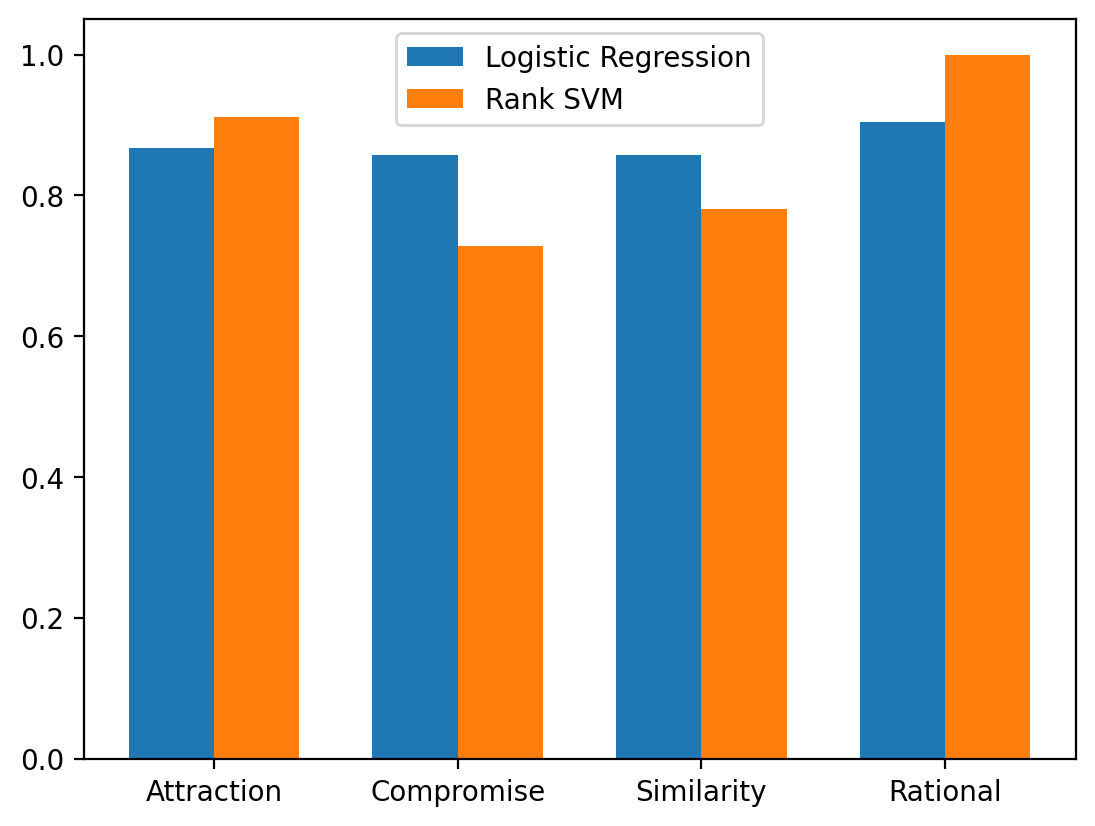

In [37]:
# Accuracy

## YOUR SOLUTION
import matplotlib.pyplot as plt

user_types = ['Attraction', 'Compromise', 'Similarity', 'Rational']
accs = [user_types_to_performance[user_type]['acc'] for user_type in user_types]
accs_ranker = [user_types_to_performance_ranker[user_type]['acc'] for user_type in user_types]
x = np.arange(len(user_types))

fig, ax = plt.subplots()
bar_width = 0.35
rects1 = ax.bar(x - bar_width/2, accs, bar_width, label='Logistic Regression')
rects2 = ax.bar(x + bar_width/2, accs_ranker, bar_width, label='Rank SVM')

ax.set_xticks(x)
ax.set_xticklabels(user_types)
ax.legend()
plt.show()


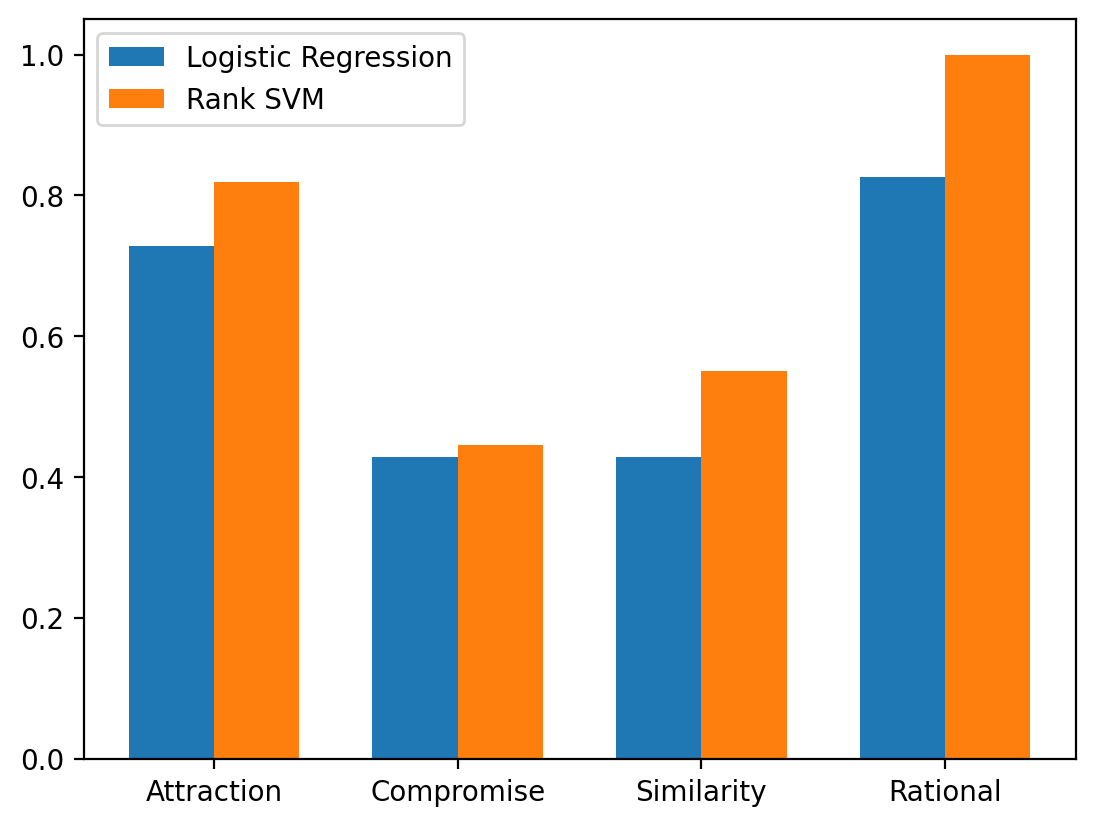

In [38]:
# Precision


## YOUR SOLUTION

import matplotlib.pyplot as plt

user_types = ['Attraction', 'Compromise', 'Similarity', 'Rational']
precisions = [user_types_to_performance[user_type]['precision'] for user_type in user_types]
precisions_ranker = [user_types_to_performance_ranker[user_type]['precision'] for user_type in user_types]
x = np.arange(len(user_types))

fig, ax = plt.subplots()
bar_width = 0.35
rects1 = ax.bar(x - bar_width/2, precisions, bar_width, label='Logistic Regression')
rects2 = ax.bar(x + bar_width/2, precisions_ranker, bar_width, label='Rank SVM')

ax.set_xticks(x)
ax.set_xticklabels(user_types)
ax.legend()
plt.show()

For the following discussion, you may refer to a pairwise ranker reminder in [course website](https://gr.cs.technion.ac.il/wc/handouts.cgi?e0iyxQZd2B3ZJyP).

2.2.4 Explain your results: What is the difference between accuracy to precision results? why is that?



```
Answer: ...
```



Per user behavior - what determines differences? What determines similarites? Would you expect these results to hold in general?



```
Answer: ...
```



##2.3 Your model

Now it is up to you to improve preformance: implement a model that **leverages behavioral context effects** with 3 features, and 10 items per slate.
Plot Accuracy and Precision per user model for baselines (from the previous section) and compare it to the newly achieved results.


Pass criteria: improve results for at least two users.

In [40]:
# run baselines

## YOUR SOLUTION
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
np.random.seed(42)

env3 = TrainContextChoiceEnvironment()
X_train, X_test, y_train, y_test = env3.generate_datasets(num_features=5, num_items=7)

user_types = ['Attraction', 'Compromise', 'Similarity', 'Rational']
user_types_to_performance = {user_type: {'acc': 0, 'precision':0} for user_type in user_types}

for i, user_type in enumerate(user_types):
    ranker = RankSVM()
    y_user_train = y_train[[user_type, 'slate_id']].to_numpy()

    y_user_test = y_test[[user_type]].to_numpy()
    ranker.fit(X_train.to_numpy(), y_user_train)
    acc = ranker.score(X_test.to_numpy(), y_user_test)
    y_pred = ranker.predict(X_test.to_numpy())
    precision = precision_score(y_user_test, y_pred, average='macro')
    user_types_to_performance_ranker[user_type]['acc'] = acc
    user_types_to_performance_ranker[user_type]['precision'] = precision

print(user_types_to_performance_ranker)

{'Attraction': {'acc': 0.9057142857142857, 'precision': 0.8075}, 'Compromise': {'acc': 0.7485714285714286, 'precision': 0.4866666666666667}, 'Similarity': {'acc': 0.7771428571428571, 'precision': 0.545}, 'Rational': {'acc': 0.9942857142857143, 'precision': 0.9883333333333333}}


/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set t

In [41]:
# your model

## YOUR SOLUTION
# Fit & Predict

from sklearn.svm import LinearSVC

np.random.seed(42)


def add_attraction_context(X, n, s, q):
    X = np.c_[X, np.zeros(X.shape[0])]
    for slate_id in range(s):
        samples_in_slate = X[slate_id*n:(slate_id+1)*n]
        preference_vector = X.max(axis=0)-X.min(axis=0)
        preference_vector_normalized = (
            preference_vector
            /np.sqrt(preference_vector@preference_vector)
        )
        # Calculate dominance and distance matrices
        dominance = np.zeros((n,n))
        distance = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                dominance[i,j] = (+1)*np.all(X[i]-X[j] >= 0) + (-1)*np.all(X[j]-X[i] >= 0)
                distance[i,j] = abs(preference_vector_normalized@(X[i]-X[j]))

        attraction_terms = (dominance*distance).sum(axis=1)
        X[slate_id*n:(slate_id+1)*n, q] = attraction_terms
    return X

def add_similarity_context(X, n, s, q):
    # Calculate preference vector
    X = np.c_[X, np.zeros(X.shape[0])]
    preference_vector = X.max(axis=0)-X.min(axis=0)
    preference_vector_normalized = (
        preference_vector
        /np.sqrt(preference_vector@preference_vector)
    )
    
    for slate_id in range(s):
        samples_in_slate = X[slate_id*n:(slate_id+1)*n]
        X_projected = np.zeros(samples_in_slate.shape)
        projection_size = np.zeros(samples_in_slate.shape[0])

        for i in range(samples_in_slate.shape[0]):
            X_projected[i, :] = samples_in_slate[i,:] -  (samples_in_slate[i,:].dot(preference_vector) / np.linalg.norm(preference_vector)) * preference_vector

        distances = np.zeros((samples_in_slate.shape[0], samples_in_slate.shape[0]))

        for i in range(samples_in_slate.shape[0]): 
            for j in range(samples_in_slate.shape[0]):
                distances[i,j] = np.linalg.norm(samples_in_slate[i,:] - samples_in_slate[j,:])

        # avoide i == j
        distances = distances + np.eye(distances.shape[0])*distances.max()

        min_distances = distances.min(axis=1) 

        X[slate_id*n:(slate_id+1)*n, q] = min_distances
    return X

def add_compromise_context(X, n, s, q, feature_num):
    X = np.c_[X, np.zeros(X.shape[0])]
    for slate_id in range(s):
        samples_in_slate = X[slate_id*n:(slate_id+1)*n]
        X_com = (samples_in_slate.max(axis=0) + samples_in_slate.min(axis=0)) / 2
        # take only the features in X_com
        X_com = X_com[:feature_num]
        d_im = np.zeros(n)
        for i in range(n):
            d_im[i] = np.linalg.norm(samples_in_slate[i,:feature_num] - X_com)
        X[slate_id*n:(slate_id+1)*n, q] = -d_im
    return X
                    
    

def transform_pairwise(X, y):
    n = X.shape[0] // np.unique(X[:, 0]).shape[0]
    s = X.shape[0] // n
    q = X.shape[1]
    feature_num = q
    
    X = add_similarity_context(X, n, s, q)
    q += 1
    X = add_compromise_context(X, n, s, q, feature_num)
    q += 1
    

    f = lambda x: 1 if x == 1 else -1
    y_new = np.random.randint(0, 2, y.shape[0] - s)
    y_new = np.array(list(map(f, y_new)))

    X_new = np.repeat(X[y[:,0]==1], repeats=n-1, axis=0) - X[y[:,0]==0]
    
    X_new = np.multiply(X_new, np.repeat(y_new, repeats=q, axis=0).reshape(-1, q))

    return X_new, y_new


class OurRankSVM(LinearSVC):
    def _init_(self, C=1.0, random_state=0):
        super()._init_(C=C, random_state=random_state)

    def fit(self, X, y):
        X_new, y_new = transform_pairwise(X, y)
        super().fit(X_new, y_new)
        return self

    def predict(self, X):
        n = X.shape[0] // np.unique(X[:, 0]).shape[0]
        s = X.shape[0] // n
        q = X.shape[1]
        feature_num = q

        X = add_similarity_context(X, n, s, q)
        q += 1
        X = add_compromise_context(X, n, s, q, feature_num)
        q += 1

        decision_score = super().decision_function(X)
        predications = []

        for slated_id in range(s):
            start = slated_id * n
            end = start + n

            predications_per_set = np.zeros(n)
            max_score_index = np.argmax(decision_score[start:end])
            predications_per_set[max_score_index] = 1

            predications.append(predications_per_set)

        return np.array(predications).reshape(-1)

In [42]:
# train model

## YOUR SOLUTION

user_types_to_performance_ranker_ours = {user_type: {'acc': 0, 'precision':0} for user_type in user_types}
for i, user_type in enumerate(user_types): 
    
    ranker = OurRankSVM()
    y_user_train = y_train[[user_type, 'slate_id']].to_numpy()
    y_user_test = y_test[[user_type]].to_numpy()
    ranker.fit(X_train.to_numpy(), y_user_train)
    acc = ranker.score(X_test.to_numpy(), y_user_test)
    y_pred = ranker.predict(X_test.to_numpy())
    precision = precision_score(y_user_test, y_pred, average='macro')
    user_types_to_performance_ranker_ours[user_type]['acc'] = acc
    user_types_to_performance_ranker_ours[user_type]['precision'] = precision

print(user_types_to_performance_ranker_ours)

/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set t

{'Attraction': {'acc': 0.8971428571428571, 'precision': 0.79}, 'Compromise': {'acc': 0.9857142857142858, 'precision': 0.9708333333333333}, 'Similarity': {'acc': 0.8228571428571428, 'precision': 0.6383333333333333}, 'Rational': {'acc': 0.9942857142857143, 'precision': 0.9883333333333333}}


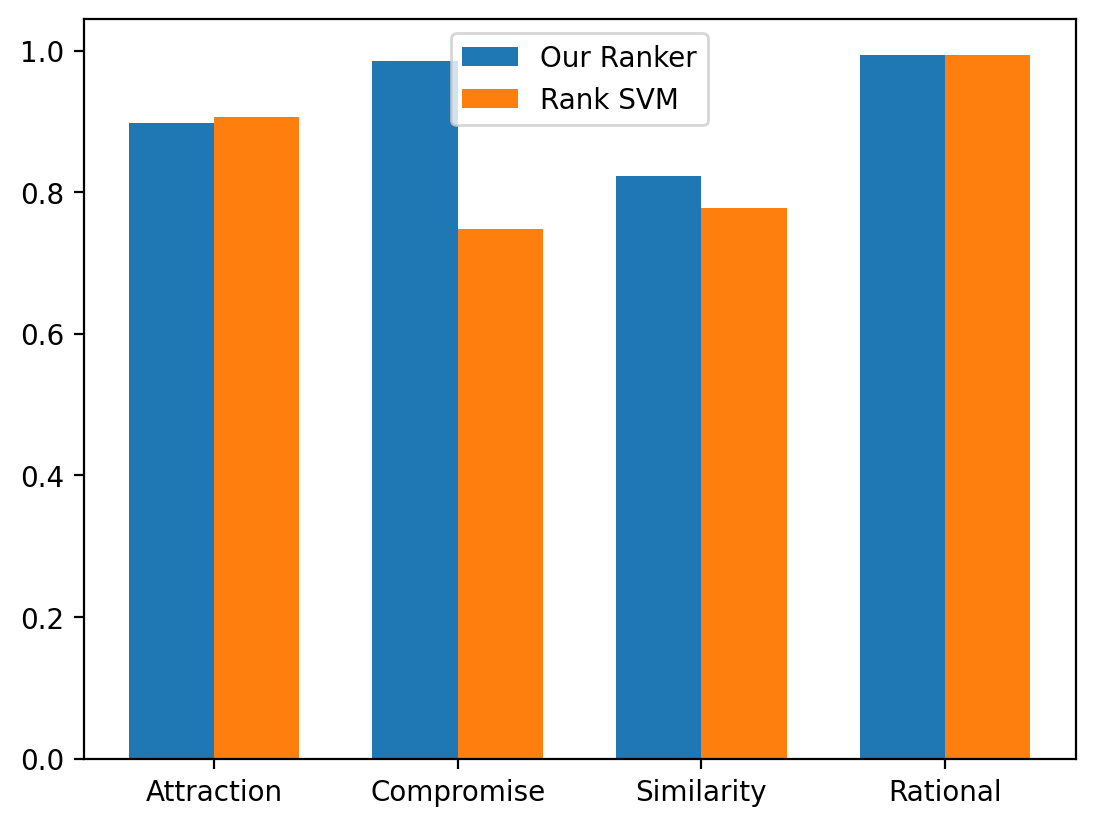

In [43]:
# Plot results

## YOUR SOLUTION

## YOUR SOLUTION
import matplotlib.pyplot as plt

user_types = ['Attraction', 'Compromise', 'Similarity', 'Rational']
accs = [user_types_to_performance_ranker_ours[user_type]['acc'] for user_type in user_types]
accs_ranker = [user_types_to_performance_ranker[user_type]['acc'] for user_type in user_types]
x = np.arange(len(user_types))

fig, ax = plt.subplots()
bar_width = 0.35
rects1 = ax.bar(x - bar_width/2, accs, bar_width, label='Our Ranker')
rects2 = ax.bar(x + bar_width/2, accs_ranker, bar_width, label='Rank SVM')

ax.set_xticks(x)
ax.set_xticklabels(user_types)
ax.legend()
plt.show()


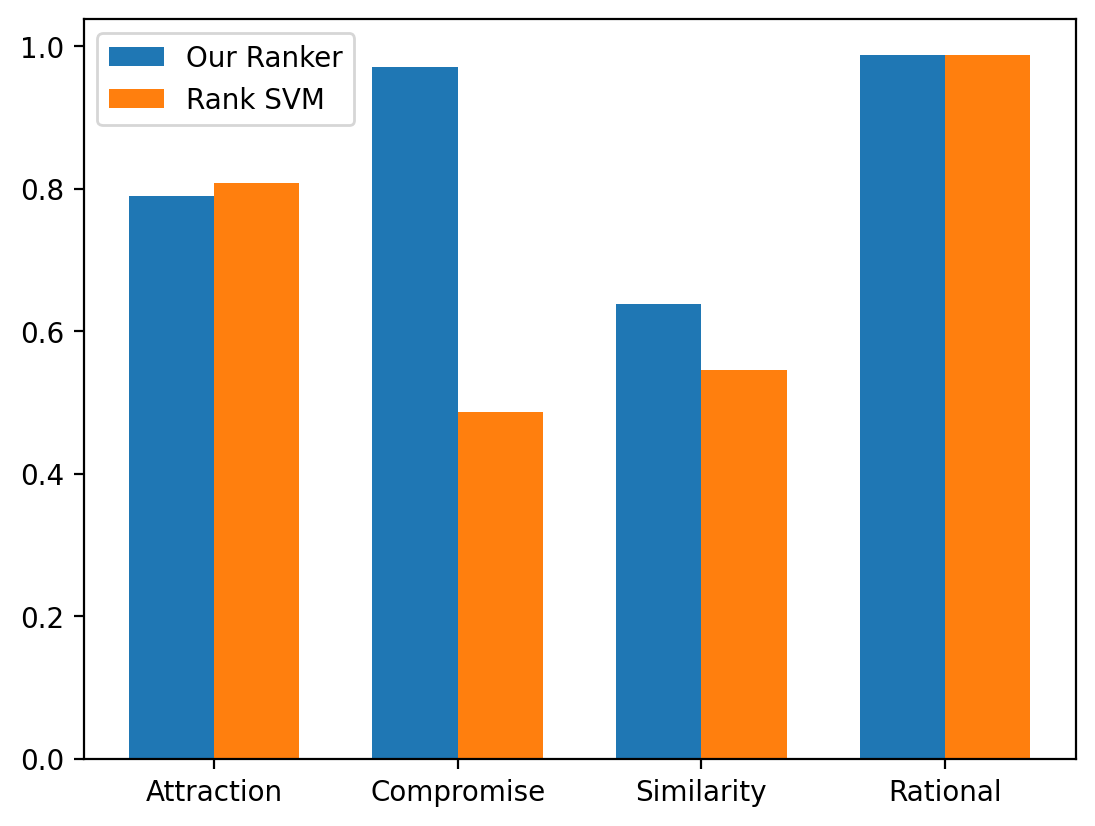

In [44]:
# Precision


## YOUR SOLUTION
import matplotlib.pyplot as plt

user_types = ['Attraction', 'Compromise', 'Similarity', 'Rational']
precisions = [user_types_to_performance_ranker_ours[user_type]['precision'] for user_type in user_types]
precisions_ranker = [user_types_to_performance_ranker[user_type]['precision'] for user_type in user_types]
x = np.arange(len(user_types))

fig, ax = plt.subplots()
bar_width = 0.35
rects1 = ax.bar(x - bar_width/2, precisions, bar_width, label='Our Ranker')
rects2 = ax.bar(x + bar_width/2, precisions_ranker, bar_width, label='Rank SVM')

ax.set_xticks(x)
ax.set_xticklabels(user_types)
ax.legend()
plt.show()

Explain what is main idea of behine this model? What enbles it to capture context effects?



```
Answer: ...
```

